<a href="https://colab.research.google.com/github/Mona1811k/Anomaly-Detection-in-CCTV-Footage-using-Deep-Learning-and-with-Alerting-Sytsem/blob/main/smart_ser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output,Video
import keras
import numpy as np
import cv2

In [ ]:
scvd_train_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train'
scvd_test_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Test'
scvd_classes = ['Normal', 'Violence','Weaponized']

In [ ]:
# Define the base directory and categories
base_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train'
categories = ['Normal', 'Violence', 'Weaponized']

In [ ]:
import os

# Function to count videos in each category
def count_videos(base_dir, categories):
    video_count = {}

    for category in categories:
        category_path = os.path.join(base_dir, category)

        if not os.path.exists(category_path):
            print(f"Directory for category '{category}' not found.")
            video_count[category] = 0
            continue

        # List all video files in the category directory
        video_files = [f for f in os.listdir(category_path) if f.endswith(('.mp4', '.avi', '.mkv'))]
        video_count[category] = len(video_files)

    return video_count

# Call the function and print the counts
video_counts = count_videos(base_dir, categories)

print("Video counts per category:")
for category, count in video_counts.items():
    print(f"{category}: {count} videos")


Video counts per category:
Normal: 872 videos
Violence: 970 videos
Weaponized: 832 videos


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 50

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
# Define the label mapping
label_mapping = {"Normal": 0, "Violence": 1, "Weaponized": 2}


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["original_path"].values  # Use the 'original_path' column
    labels = df["label"].map(label_mapping).values  # Assuming label_mapping is defined

    # Initialize placeholders for masks and features
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension
        frames = load_video(path)  # Use the full path directly
        frames = frames[None, ...]

        # Initialize placeholders for the current video's masks and features
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        # Store features and masks for the current video
        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


In [ ]:
import os
import pandas as pd

# Base directory for the dataset
base_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train'

# Define the class labels
categories = ['Normal', 'Violence', 'Weaponized']

# Initialize a list to store metadata
metadata = []

# Traverse through each category
for category in categories:
    category_path = os.path.join(base_dir, category)
    if not os.path.exists(category_path):
        print(f"Category directory '{category}' not found!")
        continue

    # List all video files in the category directory
    video_files = [f for f in os.listdir(category_path) if f.endswith(('.mp4', '.avi', '.mkv'))]
    for video_file in video_files:
        # Create full path to the video
        video_path = os.path.join(category_path, video_file)
        # Append metadata
        metadata.append({'original_path': video_path, 'label': category})

# Create a DataFrame from the metadata
train_sample_metadata = pd.DataFrame(metadata)

# Display the first few rows
print("Sample of train_sample_metadata:")
print(train_sample_metadata.head())

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(
    train_sample_metadata,
    test_size=0.1,
    random_state=42,
    stratify=train_sample_metadata['label']
)

print("Train and Test set shapes:")
print(Train_set.shape, Test_set.shape)


Sample of train_sample_metadata:
                                       original_path   label
0  /kaggle/input/smartcity-cctv-violence-detectio...  Normal
1  /kaggle/input/smartcity-cctv-violence-detectio...  Normal
2  /kaggle/input/smartcity-cctv-violence-detectio...  Normal
3  /kaggle/input/smartcity-cctv-violence-detectio...  Normal
4  /kaggle/input/smartcity-cctv-violence-detectio...  Normal
Train and Test set shapes:
(2406, 2) (268, 2)


In [ ]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

In [ ]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (2406, 20, 2048)
Frame masks in train set: (2406, 20)


In [ ]:
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.GRU(16, return_sequences=True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model([frame_features_input, mask_input], output)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 20, 16)    │     99,168 │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 8)         │        624 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │         72 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │         27 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,891 (390.20 KB)

 Trainable params: 99,891 (390.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes=3)
test_labels_one_hot = to_categorical(test_labels, num_classes=3)

# Ensure model is compiled only once, before calling fit
model = keras.Model([frame_features_input, mask_input], output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
checkpoint = keras.callbacks.ModelCheckpoint('./best_weights.weights.h5',
                                              save_weights_only=True,
                                              save_best_only=True)

history = model.fit(
    [train_data[0], train_data[1]],  # Frame features and masks
    train_labels_one_hot,  # One-hot encoded labels
    validation_data=([test_data[0], test_data[1]], test_labels_one_hot),  # One-hot encoded validation labels
    callbacks=[checkpoint],
    epochs=200,
    batch_size=8
)


Epoch 1/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5957 - loss: 0.8041 - val_accuracy: 0.5261 - val_loss: 0.9334
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5907 - loss: 0.7907 - val_accuracy: 0.5187 - val_loss: 0.8993
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5883 - loss: 0.7859 - val_accuracy: 0.5299 - val_loss: 0.8955
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5568 - loss: 0.8040 - val_accuracy: 0.5336 - val_loss: 0.8694
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5892 - loss: 0.7793 - val_accuracy: 0.5224 - val_loss: 0.8753
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5968 - loss: 0.7613 - val_accuracy: 0.5261 - val_loss: 0.8852
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5855 - loss: 0.7582 - val_accuracy: 0.5634 - val_loss: 0.8636
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5897 - loss: 0.7420 - val_accu

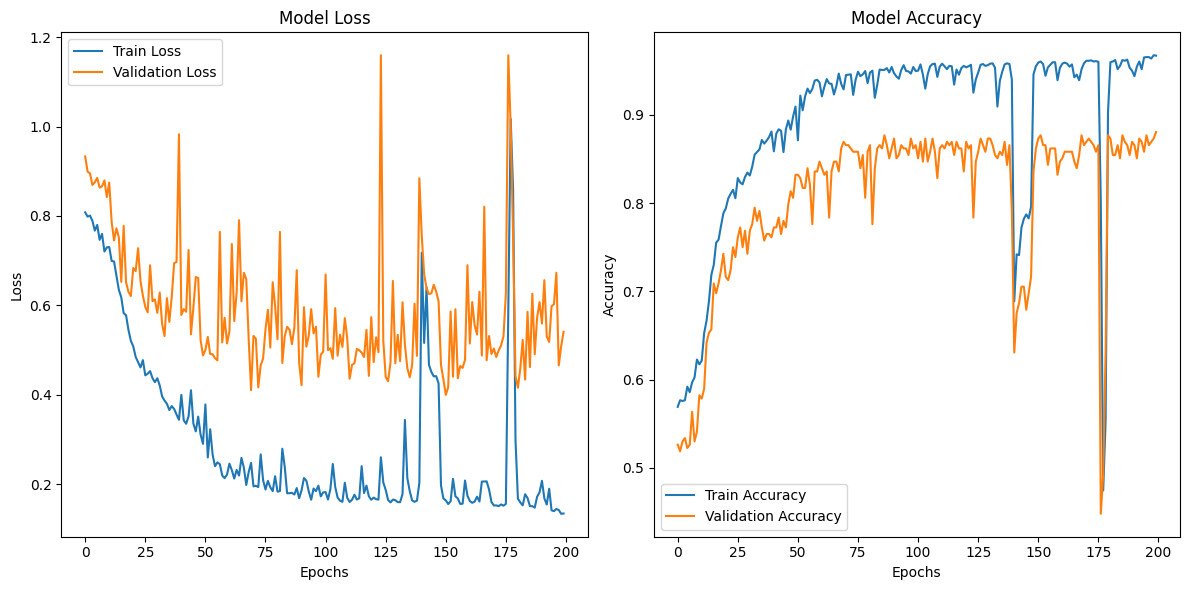

In [ ]:
import matplotlib.pyplot as plt

# Extract the history of accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


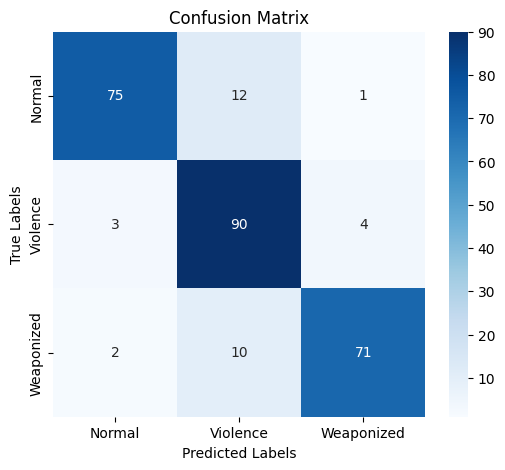

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.85      0.89        88
    Violence       0.80      0.93      0.86        97
  Weaponized       0.93      0.86      0.89        83

    accuracy                           0.88       268
   macro avg       0.89      0.88      0.88       268
weighted avg       0.89      0.88      0.88       268



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the labels for the test data
y_pred = model.predict([test_data[0], test_data[1]])
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the max probability for each prediction
y_true = np.argmax(test_labels_one_hot, axis=1)  # Get the true labels from one-hot encoding

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Violence', 'Weaponized'],
            yticklabels=['Normal', 'Violence', 'Weaponized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
cr = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Violence', 'Weaponized'])
print("Classification Report:\n", cr)


In [ ]:
# Save the entire model (architecture, weights, optimizer)
model.save('GRU.h5')


In [ ]:
from keras.models import load_model
model = load_model('GRU.h5')

In [ ]:
pip list

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Package                                  Version            Editable project location
---------------------------------------- ------------------ -------------------------
absl-py                                  1.4.0
accelerate                               1.1.1
aiobotocore                              2.15.2
aiofiles                                 22.1.0
aiohttp                                  3.9.5
aioitertools                             0.12.0
aiosignal                                1.3.1
aiosqlite                                0.20.0
albucore                                 0.0.20
albumentations                           1.4.21
alembic                                  1.14.0
altair                                   5.5.0
annotated-types                          0.7.0
annoy                                    1.17.3
ansicolors                               1.1.8
anyio                                    4.4.0
apache-beam                              2.46.0
appdirs             

In [ ]:
from tensorflow.keras import layers

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))  # Input shape for the sequence data
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")  # Input mask

# Convolutional layers to process the frame features
x = layers.Conv1D(32, 3, activation="relu", padding="same")(frame_features_input)  # 1D Conv Layer
x = layers.MaxPooling1D(2)(x)  # MaxPooling layer to downsample
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)  # Another Conv Layer
x = layers.MaxPooling1D(2)(x)  # MaxPooling layer to downsample
x = layers.Conv1D(128, 3, activation="relu", padding="same")(x)  # Another Conv Layer
x = layers.MaxPooling1D(2)(x)  # MaxPooling layer to downsample

# Flatten the output of the Conv layers
x = layers.Flatten()(x)

# Dropout layer for regularization
x = layers.Dropout(0.4)(x)

# Dense layer for final representation
x = layers.Dense(128, activation="relu")(x)

# Output layer for classification (3 classes)
output = layers.Dense(3, activation="softmax")(x)

# Define the model
model = keras.Model([frame_features_input, mask_input], output)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary of the model architecture
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 20, 32)    │    196,640 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 10, 32)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 64)    │      6,208 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 5, 64)     │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 128)    │     24,704 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 2, 128)    │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 256)       │          0 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        387 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 260,835 (1018.89 KB)

 Trainable params: 260,835 (1018.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
train_labels_one_hot = to_categorical(train_labels, num_classes=3)
test_labels_one_hot = to_categorical(test_labels, num_classes=3)

# Fit the model
checkpoint = keras.callbacks.ModelCheckpoint('./cnn_best_weights.weights.h5',
                                              save_weights_only=True,
                                              save_best_only=True)

history = model.fit(
    [train_data[0], train_data[1]],  # Frame features and masks
    train_labels_one_hot,  # One-hot encoded labels
    validation_data=([test_data[0], test_data[1]], test_labels_one_hot),  # One-hot encoded validation labels
    callbacks=[checkpoint],
    epochs=200,
    batch_size=8
)


Epoch 1/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3687 - loss: 1.1451 - val_accuracy: 0.3993 - val_loss: 1.0672
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4365 - loss: 1.0487 - val_accuracy: 0.3918 - val_loss: 1.0692
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4224 - loss: 1.0499 - val_accuracy: 0.4291 - val_loss: 1.0233
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4369 - loss: 1.0305 - val_accuracy: 0.4254 - val_loss: 1.0345
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4768 - loss: 0.9853 - val_accuracy: 0.4739 - val_loss: 0.9619
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4761 - loss: 0.9601 - val_accuracy: 0.4813 - val_loss: 0.9480
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5071 - loss: 0.9318 - val_accuracy: 0.4627 - val_loss: 0.9566
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4986 - loss: 0.9352 - val_acc

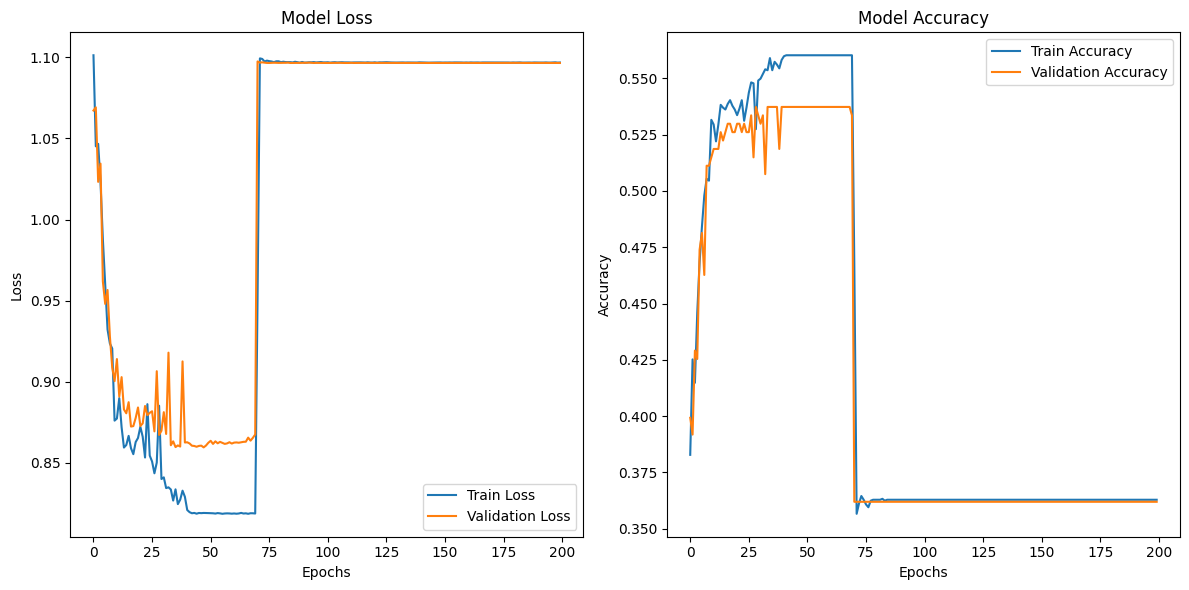

In [ ]:
import matplotlib.pyplot as plt

# Extract the history of accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


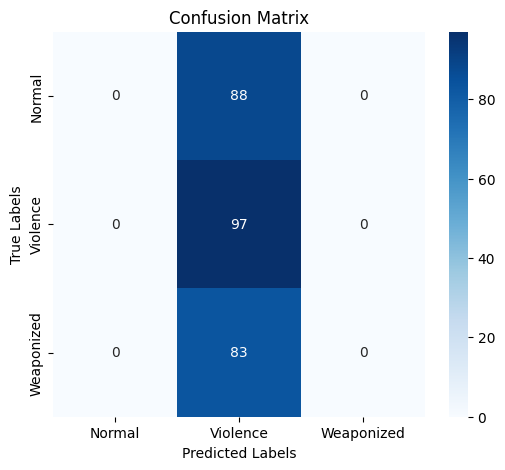

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        88
    Violence       0.36      1.00      0.53        97
  Weaponized       0.00      0.00      0.00        83

    accuracy                           0.36       268
   macro avg       0.12      0.33      0.18       268
weighted avg       0.13      0.36      0.19       268



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the labels for the test data
y_pred = model.predict([test_data[0], test_data[1]])
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the index of the max probability for each prediction
y_true = np.argmax(test_labels_one_hot, axis=1)  # Get the true labels from one-hot encoding

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Violence', 'Weaponized'],
            yticklabels=['Normal', 'Violence', 'Weaponized'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
cr = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Violence', 'Weaponized'])
print("Classification Report:\n", cr)


In [ ]:
# Save the entire model (architecture, weights, optimizer)
model.save('CNN.h5')


In [ ]:
from keras.models import load_model
model = load_model('CNN.h5')

In [ ]:
import keras
import cv2
import numpy as np
from keras.models import load_model

# Define constants
IMG_SIZE = 224  # Image size for InceptionV3
MAX_SEQ_LENGTH = 20  # Adjusted to match model's expected sequence length
NUM_FEATURES = 2048  # Features from InceptionV3 (features per frame)

# Load the model
model = load_model('GRU.h5')

# Function to load and preprocess a single video
def load_single_video(path, max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # Convert from BGR to RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

# Crop the center square of the frame
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y + min_dim, start_x:start_x + min_dim]

# Preprocess the frames (extract features using InceptionV3)
def preprocess_frames(frames):
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    frames = preprocess_input(frames)  # Preprocess the frames
    features = feature_extractor.predict(frames)
    return features

# Load and preprocess the video
video_path = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted/Test/Normal/t_n010_converted.avi'  # Replace with your video path
frames = load_single_video(video_path)
features = preprocess_frames(frames)

# Limit the number of frames to 20 (if necessary)
features = features[:MAX_SEQ_LENGTH]  # Shape: (20, 2048)
features = features[None, :, :]  # Shape: (1, 20, 2048) (batch_size, sequence_length, num_features)
mask = np.ones((1, len(features[0])))  # Mask for all frames (1 = not masked)

# Predict the label
prediction = model.predict([features, mask])

# Print the predicted class
class_labels = ['Normal', 'Violence', 'Weaponized']
predicted_class = class_labels[np.argmax(prediction)]
print(f"Predicted class: {predicted_class}")
